# Домашнее задание №7: деревья, случайный лес 

## Часть 1: основы построения решающие дерева



### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

$H(p_1,...,p_{10}) = -\sum_{i=1}^{10}p_i \ln{p_i} = 0.5$

In [276]:
np.round(- 0.8*np.log(0.8) - 0.2*np.log(0.2), 2)

0.5

#### (*・‿・)ノ⌒*:･ﾟ✧  0.5

### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

$Q_G(R_m, j, s) = F_G(R_m) - \frac{N_l}{N_m}F_G(R_l) - \frac{N_r}{N_m}F_G(R_r)$

$F_G(R_m) = \sum_{k} p_k(1-p_k)$

У нас идеально разбилась вершина, в правом и левом листе разделились 2 класса, а значит для индекса Джини мы получим нулевое значение. Тогда посчитаем индекс Джини для исходной вершины, и получим, что он равняется $ 0.8 \cdot 0.2 +  0.2 \cdot 0.8 - 0 \cdot 1 - 1 \cdot 0 $

#### (￣▽￣)/♫•*¨*•.¸¸♪  0.32

### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

Будем считать среднее в этом листе, для того чтобы найти предсказание модели

In [10]:
a =  [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(np.mean(a))

40.6


#### ༼ つ ◕_◕ ༽つ  40.6

## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию find_best_split, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете Boston из sklearn.

In [186]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

#print(boston["DESCR"])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. 

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

In [279]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака (?)
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
     
    # Регрессия только для числовых переменных, так что тут нет необходимости выделять по feature_type  
    
    if task == 'regression':
        Q_array = []
        thresholds = np.unique(feature_vector)
        tmp = np.append([0], thresholds[0:-1])
        thresholds += tmp
        thresholds = np.true_divide(thresholds, 2)
        for t in thresholds:
            R_l_mask, R_r_mask = feature_vector <= t, feature_vector >= t
            R_tl, R_tr = target_vector[R_l_mask], target_vector[R_r_mask] 
            if len(R_tl) == 0 or len(R_tr)  == 0:
                thresholds = np.delete(thresholds, np.where(thresholds == t))
            else:
                q_error = -(len(R_tl) / len(target_vector)) * np.var(R_tl, axis=0) - (len(R_tr) / len(target_vector)) * np.var(R_tr, axis=0)
                Q_array.append(q_error)
        Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
        threshold_best = thresholds[np.argmax(Q_array)]
        variance_best = np.max(Q_array)
        
    # Здесь следует выделить по feature_type, тк. можем классификацию для обоих типов переменных производить 
   # Также тут будет алгоритм для бинарной классификации (в условии намекнули ;) "p_1, p_0 — доли объектов класса 1 и 0 соответственно")
    elif task == 'classification':
        Q_array = []
        
        if feature_type == 'real':
            thresholds = np.unique(feature_vector)
            tmp = np.append([0], thresholds[0:-1])
            thresholds += tmp
            thresholds = np.true_divide(thresholds, 2)
            for t in thresholds:
                R_l_mask, R_r_mask = feature_vector <= t, feature_vector >= t
                R_tl, R_tr = target_vector[R_l_mask], target_vector[R_r_mask]
                if len(R_tl) == 0 or len(R_tr)  == 0:
                    thresholds = np.delete(thresholds, np.where(thresholds == t))
                    continue
                t_l0, t_l1 = R_tl[R_tl == 0], R_tl[R_tl == 1]
                t_r0, t_r1 = R_tr[R_tr == 0], R_tr[R_tr == 1]
                H_l = 1 - (t_l0.size / R_tl.size) **2 - (t_l1.size / R_tl.size) **2
                H_r = 1 - (t_r0.size / R_tr.size) **2 - (t_r1.size / R_tr.size) **2
                q_error = - (R_tl.size / target_vector.size) * H_l - (R_tr.size / target_vector.size) * H_r
                Q_array = np.append(Q_array, q_error)   
            Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
            threshold_best = thresholds[np.argmax(Q_array)]
            variance_best = np.max(Q_array) 
            
        elif feature_type == 'categorical':
            thresholds = np.unique(feature_vector)
            Q_array = [], []
            for t in thresholds:
                R_l, R_r = feature_vector == t, feature_vector != t
                R_tl, R_tr = target_vector[R_l], target_vector[R_r]
                if len(R_tl) == 0 or len(R_tr)  == 0:
                    thresholds = np.delete(thresholds, np.where(thresholds == t))
                    continue
                t_l0, t_l1 = R_tl[R_tl == 0], R_tl[R_tl == 1]
                t_r0, t_r1 = R_tr[R_tr == 0], R_tr[R_tr == 1]
                H_l = 1 - (t_l0.size / R_tl.size) **2 - (t_l1.size / R_tl.size) **2
                H_r = 1 - (t_r0.size / R_tr.size) **2 - (t_r1.size / R_tr.size) **2    
                q_error = - (R_tl.size / target_vector.size) * H_l - (R_tr.size / target_vector.size) * H_r
                Q_array = np.append(Q_array, q_error)   
            Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
            threshold_best = thresholds[np.argmax(Q_array)]
            variance_best = np.max(Q_array) 
                 
    return thresholds, Q_array, threshold_best, variance_best      

In [280]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real")
threshold_best

6.68632

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

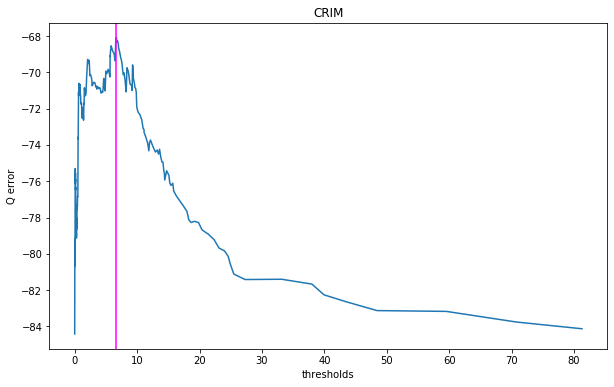

In [281]:
fig = plt.figure(figsize=(10, 6))
plt.plot(thresholds, variances)
plt.axvline(x=threshold_best, color='magenta')
plt.title("CRIM")
plt.xlabel("thresholds")
plt.ylabel("Q error")
plt.show()

### Задание 2.2 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [185]:
tab = pd.read_csv("students.csv")
tab['UNS'] = tab[' UNS']
tab = tab.drop(columns=' UNS')

In [284]:
thresholdsSTG, variancesSTG, threshold_bestSTG, variance_bestSTG = find_best_split(
    tab["STG"].astype(float).to_numpy(), 
    tab['UNS'].astype(int).to_numpy(), 
    task="classification",
    feature_type="real")

thresholdsSCG, variancesSCG, threshold_bestSCG, variance_bestSCG = find_best_split(
    tab['SCG'].astype(float).to_numpy(), 
    tab['UNS'].astype(int).to_numpy(), 
    task="classification",
    feature_type="real")

thresholdsSTR, variancesSTR, threshold_bestSTR, variance_bestSTR = find_best_split(
    tab['STR'].astype(float).to_numpy(), 
    tab['UNS'].astype(int).to_numpy(), 
    task="classification",
    feature_type="real")

thresholdsLPR, variancesLPR, threshold_bestLPR, variance_bestLPR = find_best_split(
    tab['LPR'].astype(float).to_numpy(), 
    tab['UNS'].astype(int).to_numpy(), 
    task="classification",
    feature_type="real")

thresholdsPEG, variancesPEG, threshold_bestPEG, variance_bestPEG = find_best_split(
    tab['PEG'].astype(float).to_numpy(), 
    tab['UNS'].astype(int).to_numpy(), 
    task="classification",
    feature_type="real")

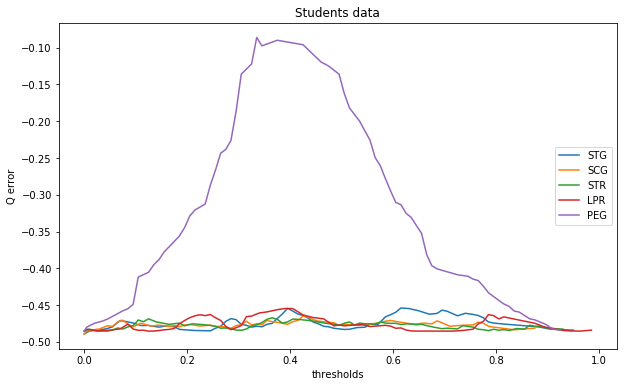

In [285]:
fig = plt.figure(figsize=(10, 6))
plt.plot(thresholdsSTG, variancesSTG, label='STG')
plt.plot(thresholdsSCG, variancesSCG, label='SCG')
plt.plot(thresholdsSTR, variancesSTR, label='STR')
plt.plot(thresholdsLPR, variancesLPR, label='LPR')
plt.plot(thresholdsPEG, variancesPEG, label='PEG')
plt.legend(loc="center right")
plt.title("Students data")
plt.xlabel("thresholds")
plt.ylabel("Q error")
plt.show()

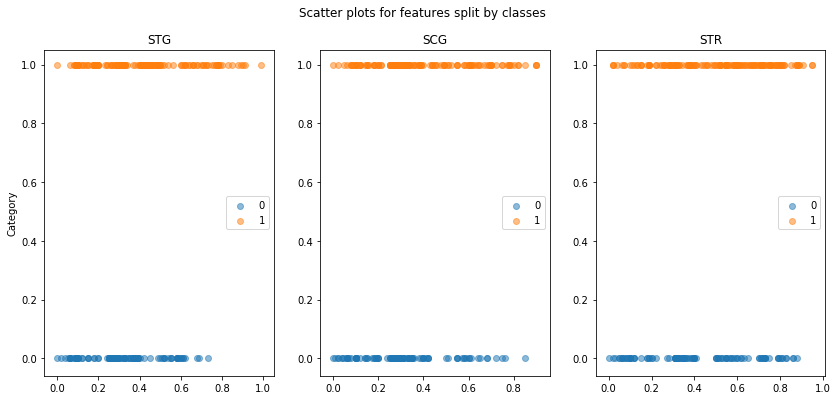

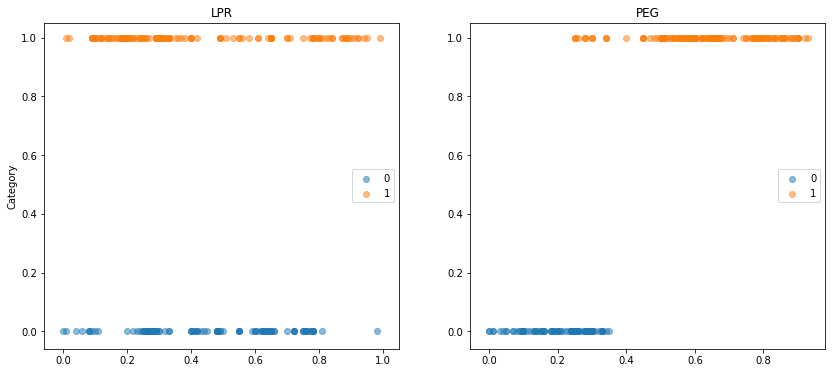

In [286]:
fig1, ax1 = plt.subplots(1, 3, figsize=(14, 6))
groups = tab.groupby('UNS')    
for name, group in groups:
    ax1[0].scatter(group['STG'], group['UNS'], marker="o", alpha=0.5, label=name)
    ax1[1].scatter(group['SCG'], group['UNS'], marker="o", alpha=0.5, label=name)
    ax1[2].scatter(group['STR'], group['UNS'], marker="o", alpha=0.5, label=name)
    ax1[0].legend(loc='center right')
    ax1[0].set_title('STG')
    ax1[0].set_ylabel('Category')
    ax1[1].legend(loc='center right')
    ax1[1].set_title('SCG')
    ax1[2].legend(loc='center right')
    ax1[2].set_title('STR')
    
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6))
for name, group in groups: 
    ax2[0].scatter(group['LPR'], group['UNS'], marker="o", alpha=0.5, label=name)
    ax2[1].scatter(group['PEG'], group['UNS'], marker="o", alpha=0.5, label=name) 
    ax2[0].legend(loc='center right')
    ax2[0].set_title('LPR')
    ax2[0].set_ylabel('Category')
    ax2[1].legend(loc='center right')
    ax2[1].set_title('PEG')
fig1.suptitle('Scatter plots for features split by classes')   
plt.show()

### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

`Ответ:`

Нужно по признаку PEG делить, потому что можно лучше всего разделить по порогу его значения, что согласуется с данными представленными на scatter plot. Несильно ошибаясь можно провести вертикальную прямую, разделяющую 2 класса.

Для тех признаков, где выборка делится почти идеально, вертикальная прямая разделяет эти 2 класса ровно, ошибка минимальна, когда есть расстояние между классами (горизонтально если смотреть). Также отчетливо видно, где достигается максимум критерия информативности, для произведения деления и выбора оптимального порога.

Для всех остальных признаков очень сложно отделить классы. Это видно по scatter plots, где классы почти невозможно отделить друг от друга, и по графику Q_error, где кажется, что нет максимума у критерия информативности. Деление производится сложно.

## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [25]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [26]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

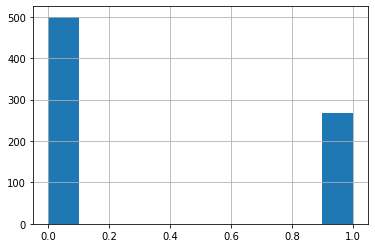

In [27]:
data['Outcome'].hist()
plt.show()

Присутствует дисбаланс, так как в выборке больше тех, у кого нет диабета (значение 0)

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [28]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [29]:
tree = DecisionTreeClassifier(random_state=1232)
bg = BaggingClassifier(tree, n_estimators=50, random_state=100)
bg.fit(X_train, y_train)
bg_pred = bg.predict(X_test)
print(f'accuracy: {np.round(accuracy_score(y_test, bg_pred), 3)}',
      f'precision: {np.round(precision_score(y_test, bg_pred), 3)}',
      f'recall: {np.round(recall_score(y_test, bg_pred), 3)}',
      f'auc_roc: {np.round(roc_auc_score(y_test, bg_pred), 3)}',
      sep='\n'
     )

accuracy: 0.766
precision: 0.698
recall: 0.682
auc_roc: 0.75


### Задание 3.2 (1 балл)

Теперь обучите `Random Forest` с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [30]:
rf = RandomForestClassifier(n_estimators=50, random_state=122)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(f'accuracy: {np.round(accuracy_score(y_test, rf_pred), 3)}',
      f'precision: {np.round(precision_score(y_test, rf_pred), 3)}',
      f'recall: {np.round(recall_score(y_test, rf_pred), 3)}',
      f'auc_roc: {np.round(roc_auc_score(y_test, rf_pred), 3)}',
      sep='\n'
     )

accuracy: 0.801
precision: 0.75
recall: 0.716
auc_roc: 0.785


Random Forest Classifier оказался незначительно, но все же лучше, чем Bagging Classifier. Связано это с тем, что в случайном лесу деревья строятся также и на случайных признаках (среди которых выбирается наилучший предикат при жадном построении деревьев), тогда как бэггинг является средним по ансамблю одного и того же дерева просто на разных бутстрапированных выборках. Бэггинг склонен к переобучению, тогда как случайный лес не переобучается (поправка: с ростом числа деревьев).

> Random forest does not overfit. You can run as many trees as you want. **Leo Breiman**

### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [76]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV

По сетке через GridSearch подберем лучшие значения для минимального количества объектов в листе (min_samples_leaf) и количества деревьев (n_estimators) 

In [120]:
param_test1 = {
    'n_estimators':range(10, 1500, 100),
    'min_samples_leaf':range(1, 150, 10)
}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=27), n_jobs=4,
             param_grid={'min_samples_leaf': range(1, 150, 10),
                         'n_estimators': range(10, 1500, 100)},
             scoring='roc_auc')

In [122]:
gsearch1.best_params_, gsearch1.best_score_

({'min_samples_leaf': 11, 'n_estimators': 310}, 0.8229242740392977)

Таким образом, получаем, что оптимальными значениями для данных гиперпараметров будут:

`min_samples_leaf = 11`

`n_estimators = 310` 

При этом лучшее значение `AUC-ROC` составит 0.82.

Построим сводную таблицу, чтобы по ней вывести heatmap

In [147]:
pvt = pd.pivot_table(pd.DataFrame(gsearch1.cv_results_), 
                     values='mean_test_score', columns='param_n_estimators', index='param_min_samples_leaf')

In [148]:
pvt

param_n_estimators,10,110,210,310,410,510,610,710,810,910,1010,1110,1210,1310,1410
param_min_samples_leaf,,,,,,,,,,,,,,,
1,0.750019,0.807012,0.810835,0.812313,0.815087,0.813761,0.812486,0.813891,0.814593,0.813344,0.812955,0.813306,0.812682,0.812953,0.813030
11,0.793576,0.816679,0.819952,0.822924,0.821696,0.821696,0.820207,0.819825,0.821064,0.821140,0.820744,0.821367,0.820750,0.821222,0.821606
21,0.787774,0.813431,0.814223,0.814767,0.814923,0.814221,0.814057,0.814380,0.814377,0.814380,0.814534,0.814925,0.815158,0.815163,0.815002
31,0.785490,0.808867,0.810900,0.812363,0.810975,0.809026,0.809644,0.808947,0.810108,0.810576,0.811353,0.811665,0.810965,0.811984,0.811747
41,0.778463,0.807252,0.807338,0.810050,0.809585,0.807481,0.807018,0.806389,0.808947,0.808562,0.808716,0.809107,0.810121,0.810125,0.810592
51,0.757157,0.806320,0.806180,0.807729,0.807654,0.805156,0.805236,0.805784,0.806164,0.805775,0.806400,0.807488,0.807878,0.808193,0.808503
61,0.756566,0.804404,0.804710,0.803766,0.803224,0.801363,0.801824,0.802520,0.802750,0.802667,0.802590,0.803218,0.803379,0.803540,0.804081
71,0.748769,0.799557,0.800553,0.803102,0.801157,0.799357,0.798816,0.798656,0.799744,0.801225,0.800678,0.800448,0.800414,0.801117,0.801578
81,0.751408,0.797724,0.799037,0.801079,0.799451,0.798508,0.797268,0.797659,0.797341,0.799138,0.800067,0.799684,0.800070,0.799686,0.800468


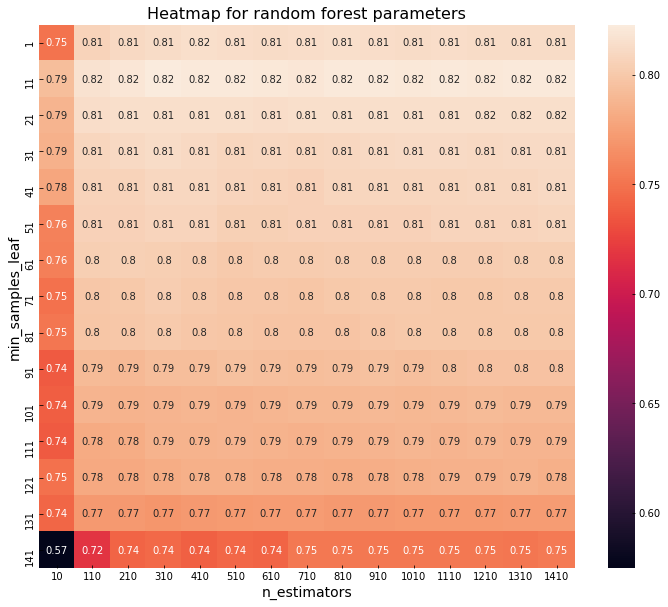

In [162]:
fig = plt.figure(figsize=(12, 10))
sns.heatmap(pvt, annot=True)
plt.title('Heatmap for random forest parameters', fontsize=16)
plt.xlabel('n_estimators', fontsize=14)
plt.ylabel('min_samples_leaf', fontsize=14);

Heatmap также позволяет увидеть что наилучшими значениями для данных гиперпараметров будут `min_samples_leaf = 11` и `n_estimators = 310`.

Можно заметить, что при фиксировании минимального числа объектов в листе на 11, с увеличением числа деревьев выше 100 происходит незначительное увеличение качества, максимальное значение ROC-AUC достигает при 310 деревьях, далее с ростом числа деревьев качество совсем незначительно снижается. 

Если же зафиксировать количество деревьев на 310, можно заметить что с увеличением минимального количества объектов в листе качетсво падает, что связано с переобучением.

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [166]:
rand_forest = RandomForestClassifier(n_estimators=310, min_samples_leaf=11, random_state=122)
rand_forest.fit(X_train, y_train)
rand_forest_pred = rand_forest.predict(X_test)

In [195]:
df = pd.DataFrame({'Importance level': rand_forest.feature_importances_}, index = X.columns)

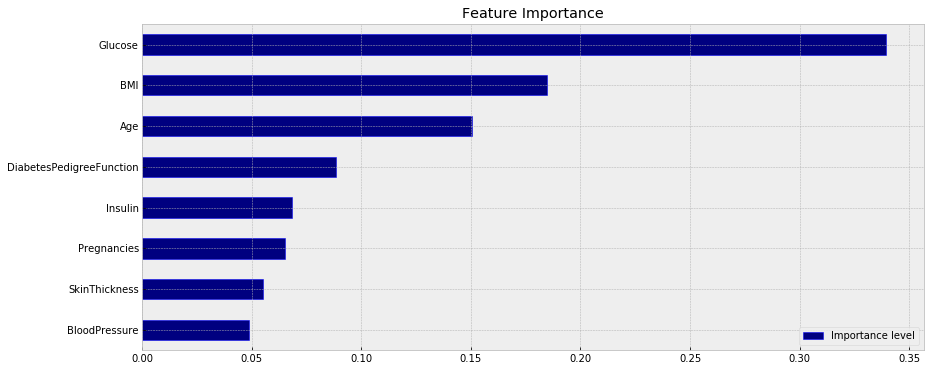

In [194]:
df.sort_values('Importance level',ascending=True).plot.barh(color='navy',figsize=(14, 6),
                                                            edgecolor='b', title='Feature Importance');

Самым важным признаком в определении диабета оказался признак Glucose, что вполне логично. Вторым по важности является BMI, третьим Age.